# Introducing PINNs

## Forward Problem

A Physics-Informed Neural Network (PINN) is a type of neural network that is trained not just on data, but also on physical laws expressed as differential equations. We use a custom loss function and try to minimize it

A typical PINN loss consists of:

**1. Initial Condition Loss**  
This ensures the neural network satisfies the initial conditions of the problem, such as:

$$
u(0) = u_0, \quad \frac{du}{dt}(0) = v_0
$$

**2. Physics Loss (ODE or PDE Residual)**  
This term forces the network output u(t) to satisfy the given physical law. For example, for an ODE like:

$$
\frac{d^2u}{dt^2} + \mu \frac{du}{dt} + k u = 0
$$

we enforce that:

$$
\text{residual} = \frac{d^2u}{dt^2} + \mu \frac{du}{dt} + k u \approx 0
$$

across a range of time points t ϵ [0, T].


Thus, a typical loss function looks like:

$$
\mathcal{L}(\theta) =
\lambda_1 \left(u_{\text{PINN}}(t = 0; \theta) - u_0 \right)^2
+ \lambda_2 \left( \left. \frac{d u_{\text{PINN}}}{dt} \right|_{t = 0; \theta} - v_0 \right)^2
+ \frac{\lambda_3}{N} \sum_{i=1}^{N}
\left( \left[ m \frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\text{PINN}}(t_i; \theta) \right)^2
$$

Here, N is the total no. of points which we want to use to calculate the physics loss.



Below, we try to code a PINN that model the oscillation problem:

### Underdamped Harmonic Oscillator

We consider the second-order ordinary differential equation (ODE) governing a damped harmonic oscillator:

$$
\frac{d^2 u}{dt^2} +  \mu  \frac{du}{dt} + k u = 0
$$

with the following initial conditions:

$$
u(0) = 1, \quad \frac{du}{dt}(0) = 0
$$

This describes an **underdamped oscillator** when the damping coefficient \mu is small relative to the natural frequency.

###  Analytical Solution

For the underdamped case  $$\mu < 2 \sqrt{k}$$ the analytical solution is:

$$
u(t) = 2A e^{- δ t} \cos(\phi + \omega t)
$$

where:

- \$ δ = \frac{\mu}{2} \$ is the damping factor
- \$ \omega = \sqrt{ω_0^2 - d^2} \$ is the damped angular frequency
- \$ \phi = \tan^{-1}\left(-\frac{\delta}{\omega}\right) \$
- \$ A = \frac{1}{2 \omega \cos(\phi)} \$

###  Parameter Values Used

We use the following values in our implementation:

- Damping factor: \$ \delta = 2 \$
- Natural angular frequency: \$ \omega_0 = 20 \$

These values ensure an underdamped system (since \$ \mu^2 < 4k \)$, producing decaying oscillations.




In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def exact_soln(delta, omega, t):      # we define the know exact solution for the problem we wish to model
  omega = np.sqrt(omega**2 - delta**2)
  phi = np.arctan(-delta / omega)
  A = 1 / (2 * np.cos(phi))
  cos = torch.cos(phi + omega * t)
  exp = torch.exp(-delta * t)
  u = exp * 2 * A * cos
  return u

class my_nn(nn.Module):     # defining our neural network
  def __init__(self, n_in_neurons, n_out_neurons, n_hidden_neurons, n_hidden_layers):
    super().__init__()
    activation = nn.Tanh

    # the first layer that takes in the inputs
    self.in_layer = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons),
        activation()
    )

    # hidden layers
    self.hidden_layers = nn.Sequential(*[
        nn.Sequential(
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            activation()
        )
        for _ in range(n_hidden_layers)
    ]
    )
    # layer that gives the output
    self.out_layer = nn.Linear(n_hidden_neurons, n_out_neurons)

  def forward(self, x):     # forward pass
    x = self.in_layer(x)
    x = self.hidden_layers(x)
    x = self.out_layer(x)
    return x

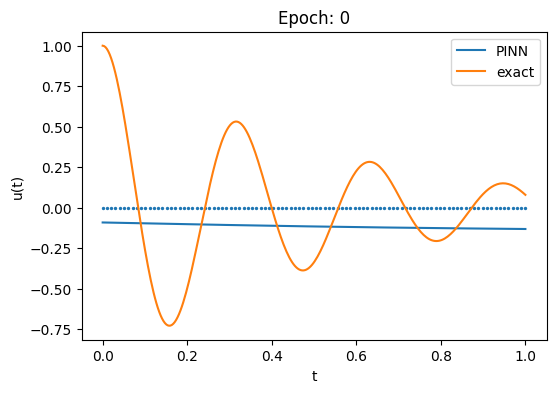

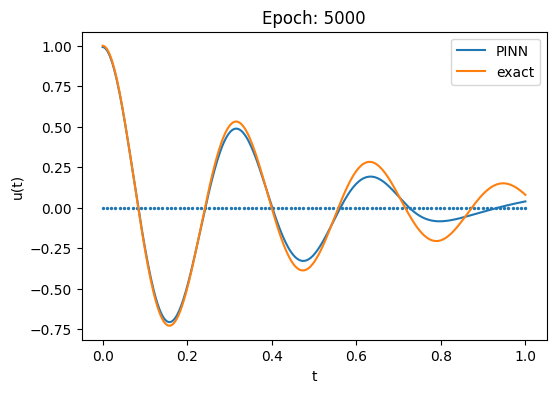

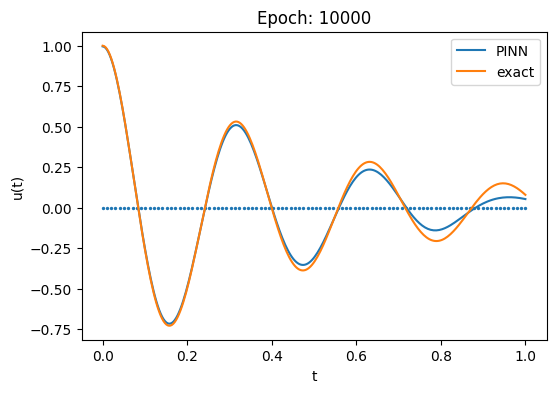

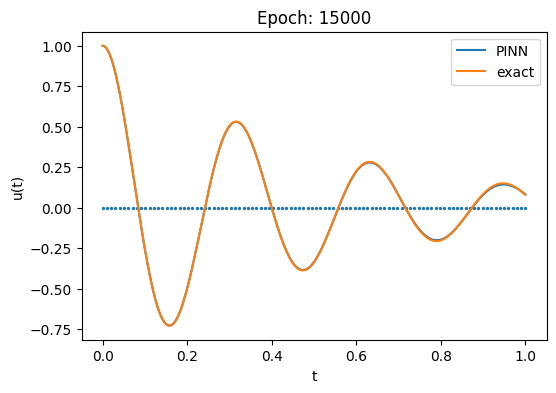

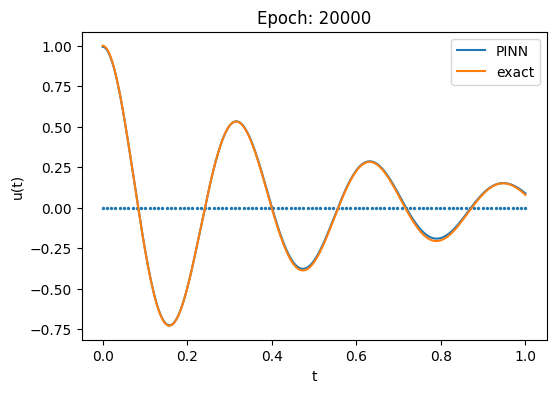

In [6]:
torch.manual_seed(123)

pinn = my_nn(1,1,32,3)    # initializing out neural network

t_initial_conditions = torch.tensor(0.).view(-1,1).requires_grad_(True)     # time vector for the initial conditions available

t_physics_loss = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)    # time vector to calculate the physics loss

delta, omega = 2, 20
mu, k = 2*delta, omega**2
t_test = torch.linspace(0,1,300).view(-1,1)     # to compare results at the end
u_exact = exact_soln(delta, omega, t_test)      # exact solution
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)    # we use the Adam optimizer
for epoch in range(20001):
  optimizer.zero_grad()

  lambda1, lambda2, lambda3 = 1.0, 0.01, 0.0001     # weights for individual losses (had to be tuned)

  # make prediction at initial conditions and calculate loss1
  u_initial_conditions = pinn(t_initial_conditions)
  loss1 = (torch.squeeze(u_initial_conditions) - 1)**2

  # calculate gradient by the model at initial conditions and calculate loss2
  dudt = torch.autograd.grad(u_initial_conditions, t_initial_conditions, torch.ones_like(u_initial_conditions), create_graph=True)[0]
  loss2 = (torch.squeeze(dudt) - 0)**2

  # make prediction at physics loss points, calculate single and double derivatives and calculate loss3 (differential equation loss)
  u_physics_loss = pinn(t_physics_loss)
  dudt = torch.autograd.grad(u_physics_loss, t_physics_loss, torch.ones_like(u_physics_loss), create_graph=True)[0]
  d2udt2 = torch.autograd.grad(dudt, t_physics_loss, torch.ones_like(dudt), create_graph=True)[0]
  loss3 = torch.mean(((d2udt2) + mu*dudt + k*u_physics_loss)**2)

  # backpropagate and update the parameters
  loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3
  loss.backward()
  optimizer.step()

  # plotting to compare results
  if not epoch % 5000:
    u_test = pinn(t_test).detach()
    plt.figure(figsize=(6,4))
    plt.scatter(t_physics_loss.detach()[:,0], torch.zeros_like(u_physics_loss)[:,0], s=2)
    plt.plot(t_test.detach()[:,0], u_test.detach()[:,0], label='PINN')
    plt.plot(t_test.detach()[:,0], u_exact.detach()[:,0], label='exact')
    plt.xlabel('t')
    plt.ylabel('u(t)')
    plt.title(f'Epoch: {epoch}')
    plt.legend()
    plt.show()



We can improve the result by properly tuning the hyperparameters lambda1, lambda2 and lambda3, and also by changing the number of hidden layers, neurons per layers, etc.

## Inverse Problem

Above was an example of a forward problem, wherein given physical parameters (μ, k), we try to compute the system behaviour. An inverse problem is where we are give the system behaviour and we infer unknown physical parameters from it.

Specifically, our input and output are:
- Input: noisy observations of the oscillator's displacement.
- Output: estimate $\mu$, the coefficient of friction

Similar to above, the PINN is trained to approximate the solution to the differential equation, i.e.

$$
u_{\text{PINN}}(t; \theta) ≈ u(t)
$$

where $\theta$ are all the free parameters (weights and biases) of the PINN.

The idea here is to also treat $\mu$ as a larnable parameter when training the PINN - so that we can simulate the solution and estimate the value of $\mu$ simultaneously.

### Loss Function

This time we use a slightly different loss function

$$
\mathcal{L}(\theta, μ) =
\frac{1}{N}\sum_{i=1}^{N}
\left( \left[ m \frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\text{PINN}}(t_i; \theta) \right)^2 + \frac{λ}{M}\sum_{j=1}^M (u_{\text{PINN}}(t_j; \theta) - u_{obs}(t_j))^2
$$

There are two terms in the loss function. First is the **Physics Loss**, which ensures that the learned solution is consistent with the know physical law.

The second term is the **Data Loss**, which makes sure that the solution learned by the PINN fits thethe (potentiall noisy) observations of the solution that are available.



True value of mu: 4


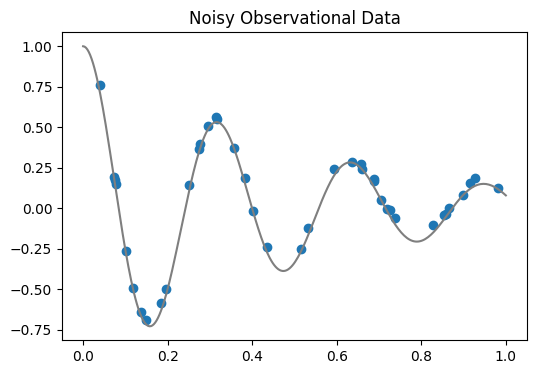

In [4]:
torch.manual_seed(123)
delta, omega = 2, 20

print(f"True value of mu: {2*delta}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_soln(delta, omega, t_obs) + 0.05*torch.rand_like(t_obs)

plt.figure(figsize=(6,4))
plt.title('Noisy Observational Data')
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test = torch.linspace(0,1,300).view(-1,1)
u_test = exact_soln(delta, omega, t_test)
plt.plot(t_test[:,0], u_test[:,0], label='Exact Solution', color="tab:grey")
plt.show()

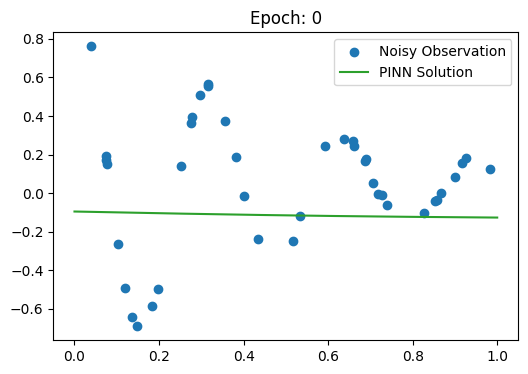

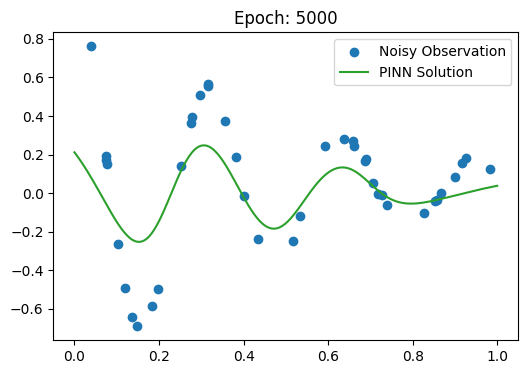

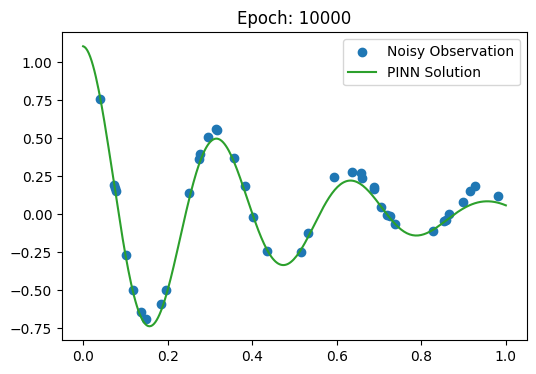

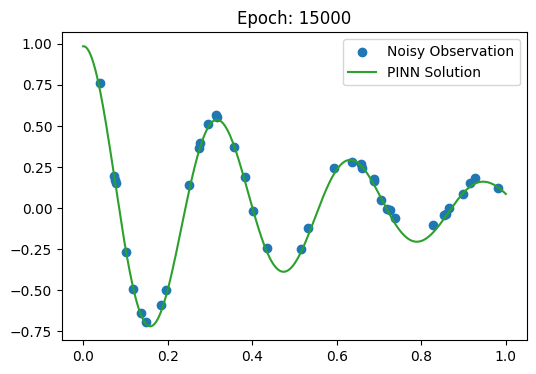

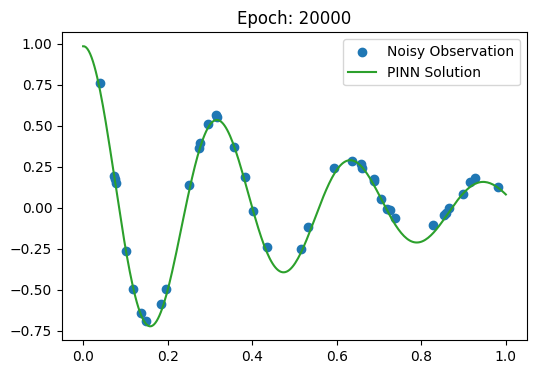

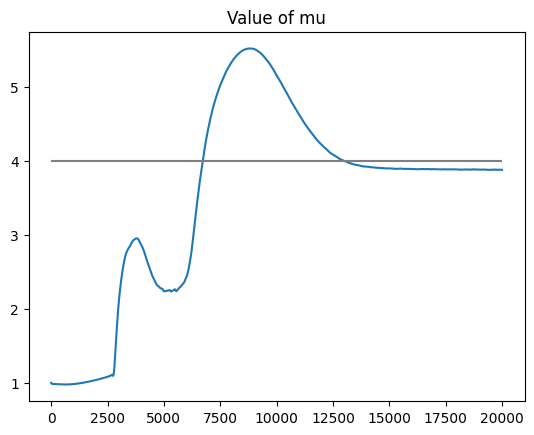

In [5]:
torch.manual_seed(123)

pinn = my_nn(1,1,32,3)

t_physics_loss = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)

_,k = 2*delta, omega**2

mu = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
optimizer = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=1e-3)
mus = []

for epoch in range(20001):
  optimizer.zero_grad()

  lambda1, lambda2 = 10.0, 1e5

  u_physics_loss = pinn(t_physics_loss)
  dudt = torch.autograd.grad(u_physics_loss, t_physics_loss, torch.ones_like(u_physics_loss), create_graph=True)[0]
  d2udt2 = torch.autograd.grad(dudt, t_physics_loss, torch.ones_like(dudt), create_graph=True)[0]
  loss1 = torch.mean(((d2udt2) + mu*dudt + k*u_physics_loss)**2)

  u = pinn(t_obs)
  loss2 = torch.mean((u - u_obs)**2)

  loss = lambda1*loss1 + lambda2*loss2
  loss.backward()
  optimizer.step()

  mus.append(mu.item())

  if epoch % 5000 == 0:
    u_test = pinn(t_test)
    plt.figure(figsize=(6,4))
    plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy Observation")
    plt.plot(t_test.detach()[:,0], u_test.detach()[:,0], label='PINN Solution', color="tab:green")
    plt.title(f'Epoch: {epoch}')
    plt.legend()
    plt.show()

plt.figure()
plt.title('Value of mu')
plt.plot(mus, label="PINN estimate")
plt.hlines(2*delta, 0, len(mus), label="True value", color="tab:grey")
plt.show()


